In [1]:
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from scipy import stats
from scipy.integrate import simpson
from scipy.optimize import minimize
from scipy.stats import kurtosis, norm
from numpy.polynomial import Polynomial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader, random_split

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Core Functions

In [3]:
# Define MLP model
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            # nn.Tanh(),
            nn.Linear(128, 64),
            nn.ReLU(),
            # nn.Tanh(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# training loop
def train(model, train_loader, val_loader, epochs=1000):
    for epoch in range(epochs):
        model.train()
        train_loss  = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output  = model(X_batch)
            loss    = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        # if epoch % 20 == 0:
        avg_loss    = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds   = model(xb)
                loss    = loss_fn(preds, yb)
                val_loss += loss.item() * xb.size(0)

        avg_train_loss  = train_loss / train_size
        avg_val_loss    = val_loss / val_size

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Optional: Reduce LR or stop early
        scheduler.step(avg_train_loss)

# get dataset ready to be used in pytorch training loop
def prepare_data(db, inds, deps, input_scaler=None, output_scaler=None):
    X           = db[inds].values
    y           = db[deps].values

    if input_scaler is None:
        input_scaler    = StandardScaler()
        X_scaled        = input_scaler.fit_transform(X)
    else:
        X_scaled        = input_scaler.transform(X)

    if output_scaler is None:
        output_scaler   = StandardScaler()
        y_scaled        = output_scaler.fit_transform(y)
    else:
        y_scaled        = output_scaler.transform(y)

    X_tensor    = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor    = torch.tensor(y_scaled, dtype=torch.float32)
    dataset     = TensorDataset(X_tensor, y_tensor)
    return dataset, input_scaler, output_scaler

# make predictions on dataset based on trained model
def make_predictions(model, dataset, input_scaler, output_scaler):
    model.eval()
    all_ins         = []
    all_preds       = []
    all_targets     = []
    dataset_loader  = DataLoader(dataset, batch_size=1024)
    with torch.no_grad():
        for xb, yb in dataset_loader:
            preds_scaled    = model(xb)
            preds           = output_scaler.inverse_transform(preds_scaled.numpy())
            targets         = output_scaler.inverse_transform(yb.numpy())

            all_preds.append(preds)
            all_targets.append(targets)
    all_preds       = np.vstack(all_preds)
    all_targets     = np.vstack(all_targets)
    return all_targets, all_preds

# Train Network on Data

## Load Data

In [4]:
folder = '/content/drive/MyDrive/Chapman/Research/RADAR/Derek/Scatter_Distribution/'

In [5]:
# db      = pd.read_csv(folder + 'db_delta_snr10.csv')
# db2     = pd.read_csv(folder + 'db_norm_snr10.csv')
db      = pd.read_csv(folder + 'db_delta_snr0_w_preds1.csv')
db2     = pd.read_csv(folder + 'db_norm_snr0_w_preds1.csv')
# db      = pd.read_csv(folder + 'db_delta_freqs_snr100_w_preds1.csv')
# db2     = pd.read_csv(folder + 'db_norm_freqs_snr0_w_preds1.csv')

print(len(db))
# print(len(db2))

687800


#### reports and metrics

In [ ]:
common_cols = db.columns.intersection(db2.columns)

means_db1 = db[common_cols].mean()
means_db2 = db2[common_cols].mean()

mean_comparison = pd.DataFrame({
    'mean_db1': np.round(means_db1, 4),
    'mean_db2': np.round(means_db2, 4)
})

print(mean_comparison)

                mean_db1   mean_db2
mean             -0.0100    -0.0093
variance          0.0494     0.0497
std               0.2055     0.2061
skew              0.0000     0.0004
kurtosis          3.5358     3.5342
inv_kurt          0.4811     0.4813
hyperskewness     0.0000     0.1333
hyperkurtosis    29.3645    32.5926
segment0_0        0.1233     0.1427
segment0_1       -0.0269    -0.0282
segment0_2       -2.8961    -3.9026
segment0_3        0.1440     0.1919
segment0_4       10.0708    15.4300
segment1_0        0.1882     0.2701
segment1_1       -1.3315    -2.7721
segment1_2        2.5546     8.8258
segment1_3       -2.9821   -12.8481
segment1_4        1.8647     6.9486
segment2_0        5.7116     9.4515
segment2_1      -27.6104   -44.7926
segment2_2       46.1148    74.5103
segment2_3      -31.8440   -51.9451
segment2_4        7.7696    12.9341
freq_0         1636.8764  1652.9889
freq_1         1685.7505  1687.0989
freq_2         1649.3994  1624.8268
freq_3         1649.3994  16

In [ ]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687800 entries, 0 to 687799
Data columns (total 39 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   loc_1          687800 non-null  float64
 1   loc_2          687800 non-null  float64
 2   loc_3          687800 non-null  float64
 3   amp_1          687800 non-null  float64
 4   amp_2          687800 non-null  float64
 5   amp_3          687800 non-null  float64
 6   mean           687800 non-null  float64
 7   variance       687800 non-null  float64
 8   std            687800 non-null  float64
 9   skew           687800 non-null  float64
 10  kurtosis       687800 non-null  float64
 11  inv_kurt       687800 non-null  float64
 12  hyperskewness  687800 non-null  float64
 13  hyperkurtosis  687800 non-null  float64
 14  segment0_0     687800 non-null  float64
 15  segment0_1     687800 non-null  float64
 16  segment0_2     687800 non-null  float64
 17  segment0_3     687800 non-nul

In [ ]:
db2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687800 entries, 0 to 687799
Data columns (total 37 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   mu1            687800 non-null  float64
 1   mu2            687800 non-null  float64
 2   sigma          687800 non-null  float64
 3   w1             687800 non-null  float64
 4   mean           687800 non-null  float64
 5   variance       687800 non-null  float64
 6   std            687800 non-null  float64
 7   skew           687800 non-null  float64
 8   kurtosis       687800 non-null  float64
 9   inv_kurt       687800 non-null  float64
 10  hyperskewness  687800 non-null  float64
 11  hyperkurtosis  687800 non-null  float64
 12  segment0_0     687800 non-null  float64
 13  segment0_1     687800 non-null  float64
 14  segment0_2     687800 non-null  float64
 15  segment0_3     687800 non-null  float64
 16  segment0_4     687800 non-null  float64
 17  segment1_0     687800 non-nul

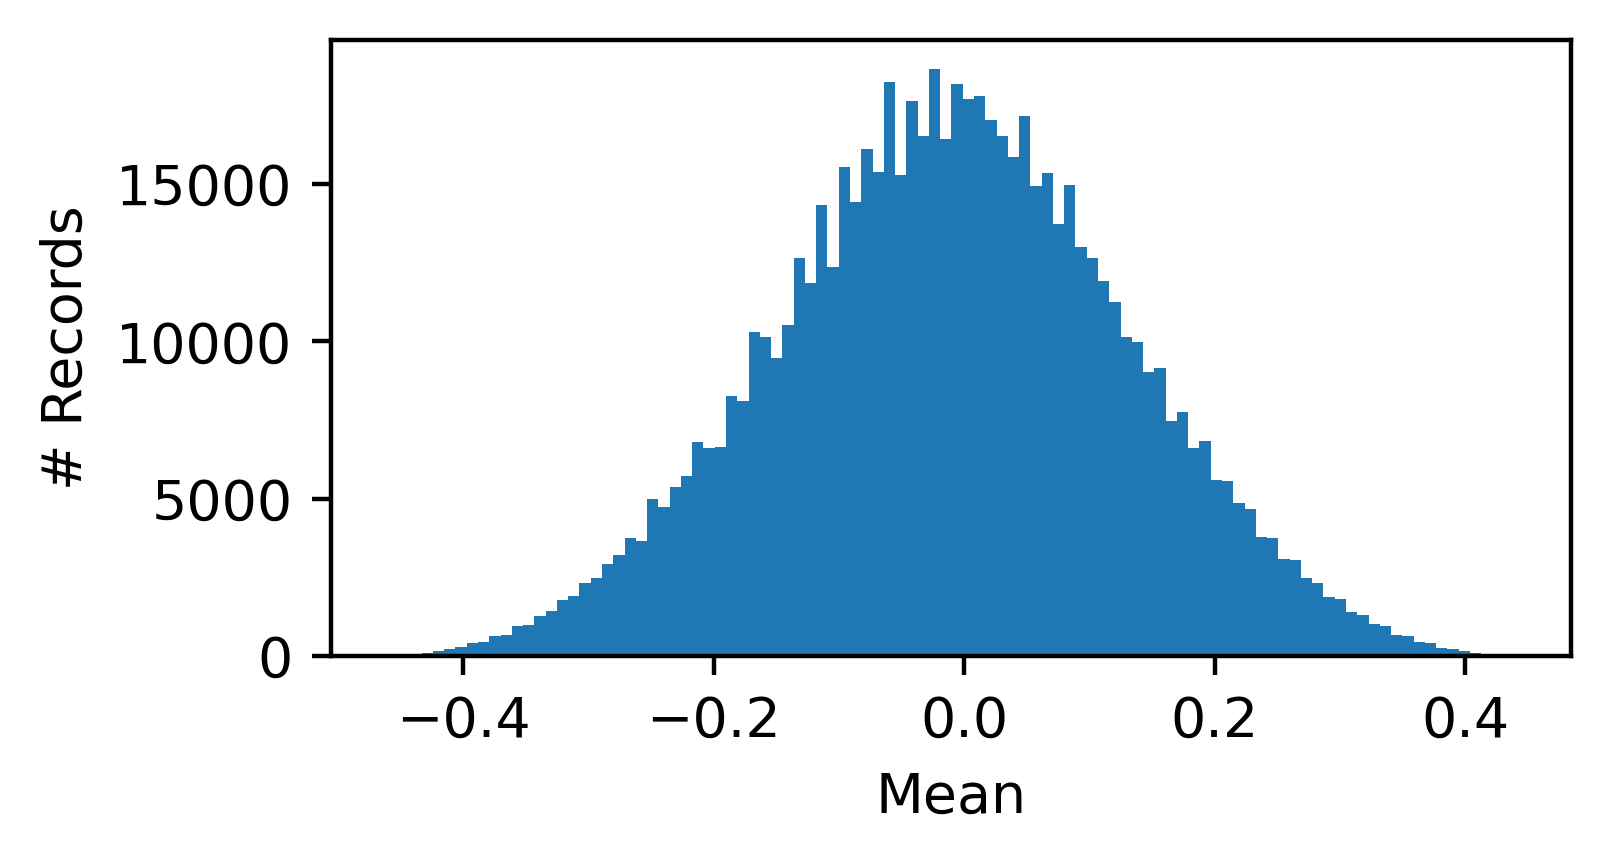

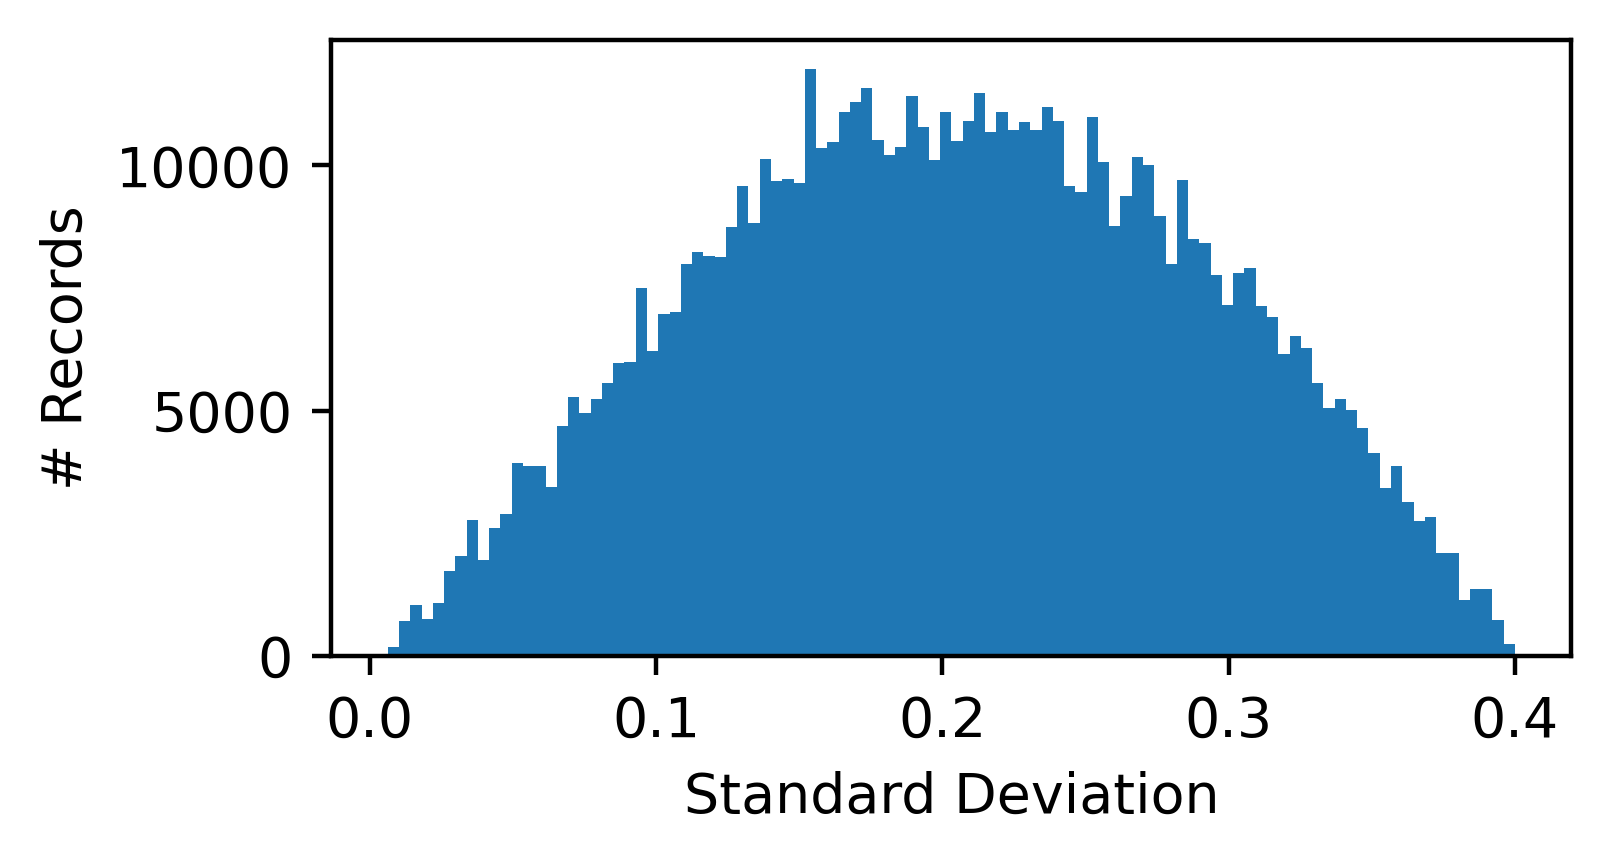

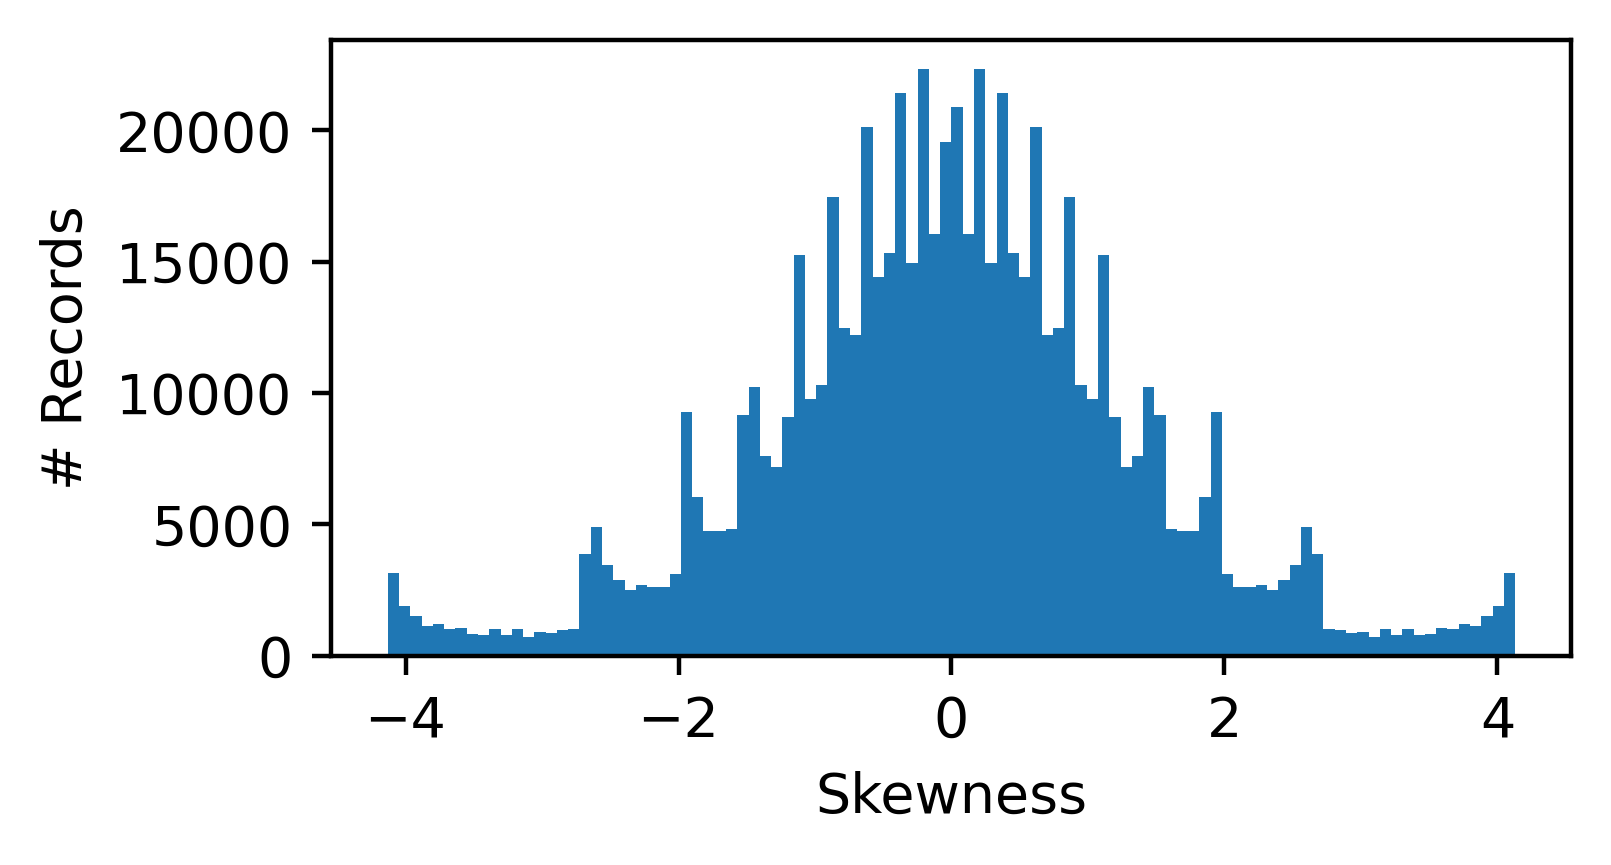

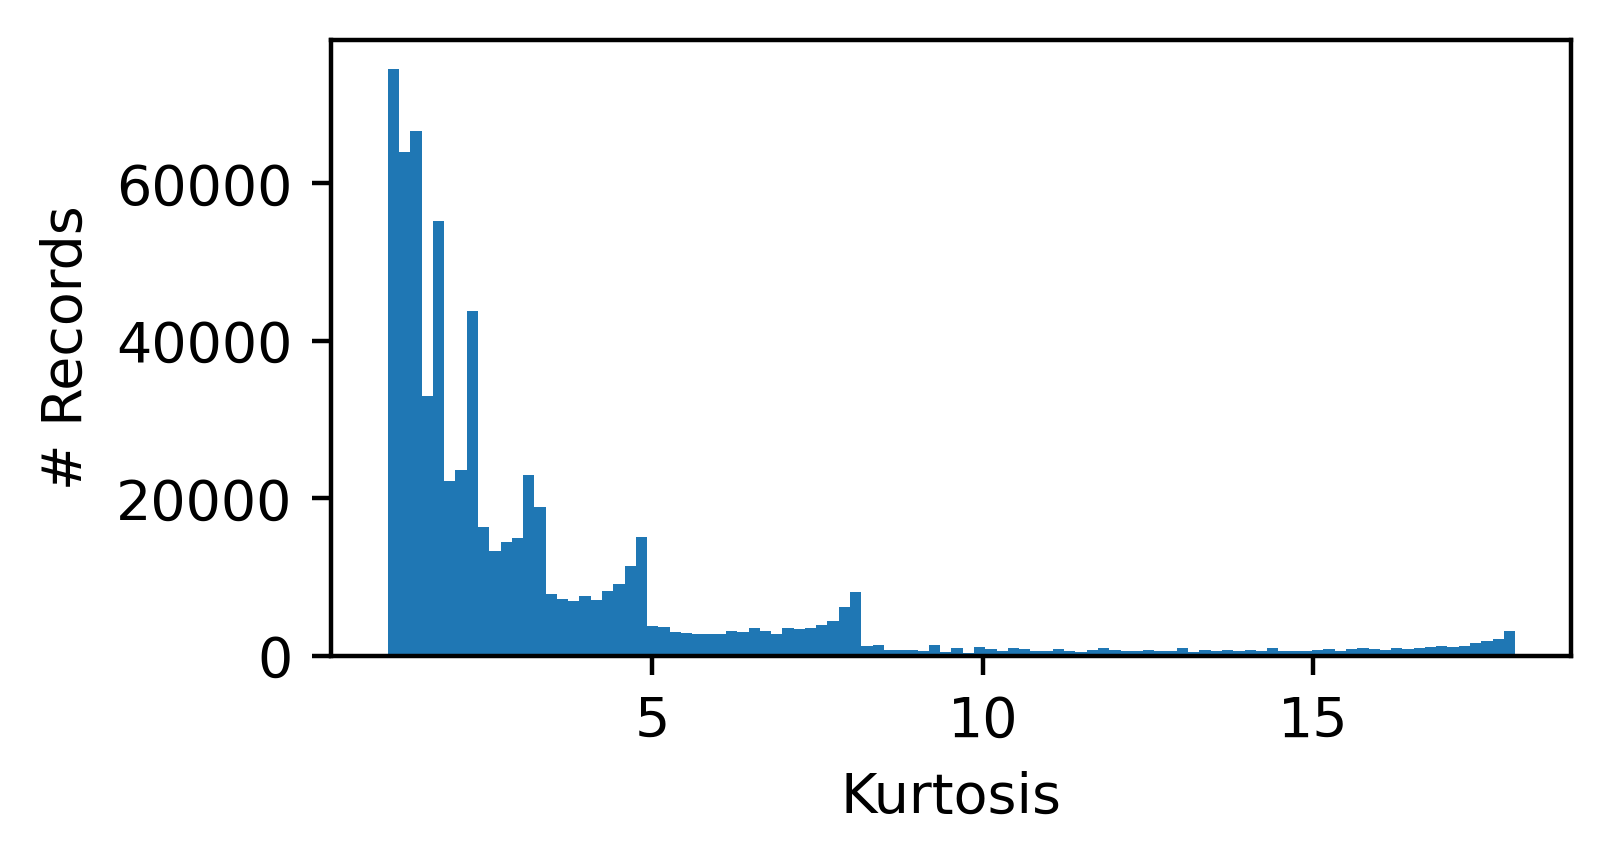

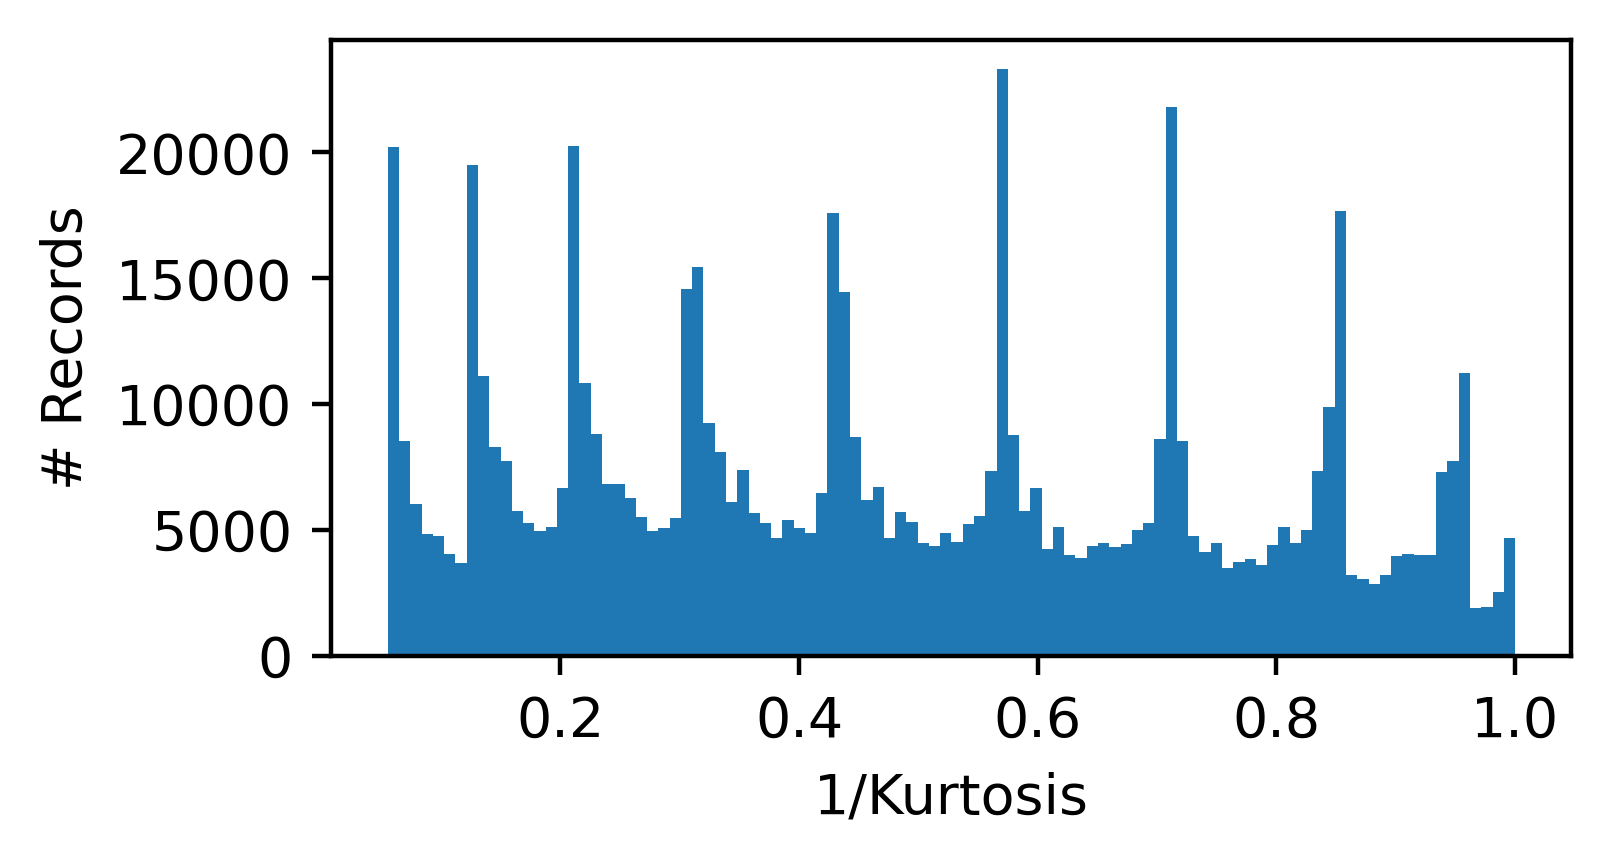

In [8]:
# plot histograms for each of mean, variance, skew, kurtosis, h-skew, and h-kurt

numbins = 100

plt.rcParams['figure.figsize'] = [4, 2]
plt.rcParams['figure.dpi'] = 400

plt.hist(db['mean'], bins=numbins)
plt.xlabel('Mean')
plt.ylabel('# Records')
plt.show()

plt.hist(db['std'], bins=numbins)
plt.xlabel('Standard Deviation')
plt.ylabel('# Records')
plt.show()

plt.hist(db['skew'], bins=numbins)
plt.xlabel('Skewness')
plt.ylabel('# Records')
plt.show()

plt.hist(db['kurtosis'], bins=numbins)
plt.xlabel('Kurtosis')
plt.ylabel('# Records')
plt.show()

plt.hist(db['inv_kurt'], bins=numbins)
plt.xlabel('1/Kurtosis')
plt.ylabel('# Records')
plt.show()

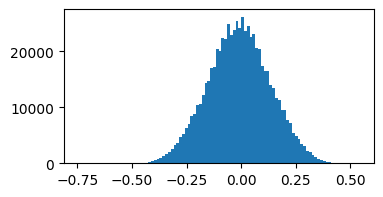

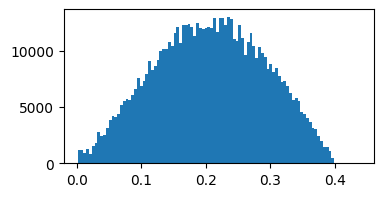

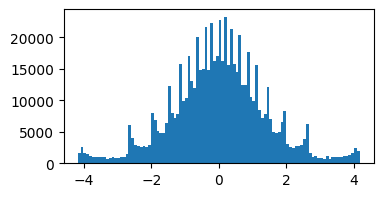

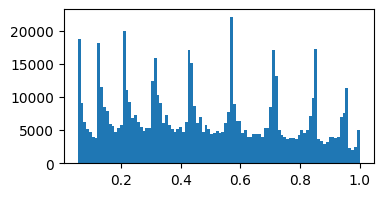

In [ ]:
plt.rcParams['figure.figsize'] = [4, 2]

plt.hist(db2['mean'], bins=100)
plt.show()

plt.hist(db2['std'], bins=100)
plt.show()

plt.hist(db2['skew'], bins=100)
plt.show()

plt.hist(db2['inv_kurt'], bins=100)
plt.show()

In [ ]:
meanstd = db['mean'].std()
varstd = db['variance'].std()
sigmastd = db['std'].std()
skewstd = db['skew'].std()
kurtstd = db['kurtosis'].std()
hskewstd = db['hyperskewness'].std()
hkurtstd = db['hyperkurtosis'].std()

print(meanstd, varstd, sigmastd, skewstd, kurtstd, hskewstd, hkurtstd)

0.14001854966417787 0.035687537738165485 0.0846558885373308 1.413028956725272 3.504840941070932 17.58783335835386 63.65935665675655


## select which data to include as independent and dependent variables

In [ ]:
segments    = 3
cols        = []

for seg in range(segments):
    for coef in range((5)):
        cols.append(f'segment{seg}_{coef}')

# for freq in range(6):
#     cols.append(f'freq_{freq}')
# cols.append('freq_delta')

In [ ]:
independents    = cols.copy()
# independents   += ['mean_pred', 'variance_pred', 'std_pred']
independents   += ['mean', 'variance', 'std']

# dependents      = ['mean', 'variance', 'std']
dependents      = ['skew', 'kurtosis', 'inv_kurt']

print(independents)
print(dependents)

['segment0_0', 'segment0_1', 'segment0_2', 'segment0_3', 'segment0_4', 'segment1_0', 'segment1_1', 'segment1_2', 'segment1_3', 'segment1_4', 'segment2_0', 'segment2_1', 'segment2_2', 'segment2_3', 'segment2_4', 'mean', 'variance', 'std']
['skew', 'kurtosis', 'inv_kurt']


## run training

In [ ]:
dataset, _in, _out  = prepare_data(db, independents, dependents)
model               = MLPRegressor(input_dim=len(independents), output_dim=len(dependents))
loss_fn             = nn.MSELoss()
optimizer           = optim.Adam(model.parameters(), lr=8e-4)
scheduler           = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=5)
val_size            = int(0.2 * len(dataset))
train_size          = len(dataset) - val_size
_train, _val        = random_split(dataset, [train_size, val_size])
train_loader        = DataLoader(_train, batch_size=512, shuffle=True)
val_loader          = DataLoader(_val, batch_size=512)

train(model, train_loader, val_loader)

Epoch 1 - Train Loss: 0.1657, Val Loss: 0.0899
Epoch 2 - Train Loss: 0.0754, Val Loss: 0.0661
Epoch 3 - Train Loss: 0.0582, Val Loss: 0.0539
Epoch 4 - Train Loss: 0.0489, Val Loss: 0.0461
Epoch 5 - Train Loss: 0.0421, Val Loss: 0.0393
Epoch 6 - Train Loss: 0.0376, Val Loss: 0.0349
Epoch 7 - Train Loss: 0.0340, Val Loss: 0.0313
Epoch 8 - Train Loss: 0.0315, Val Loss: 0.0340
Epoch 9 - Train Loss: 0.0297, Val Loss: 0.0349
Epoch 10 - Train Loss: 0.0280, Val Loss: 0.0265
Epoch 11 - Train Loss: 0.0271, Val Loss: 0.0280
Epoch 12 - Train Loss: 0.0258, Val Loss: 0.0273
Epoch 13 - Train Loss: 0.0254, Val Loss: 0.0239
Epoch 14 - Train Loss: 0.0244, Val Loss: 0.0233
Epoch 15 - Train Loss: 0.0240, Val Loss: 0.0284
Epoch 16 - Train Loss: 0.0230, Val Loss: 0.0217
Epoch 17 - Train Loss: 0.0226, Val Loss: 0.0210
Epoch 18 - Train Loss: 0.0224, Val Loss: 0.0248
Epoch 19 - Train Loss: 0.0218, Val Loss: 0.0215
Epoch 20 - Train Loss: 0.0215, Val Loss: 0.0205
Epoch 21 - Train Loss: 0.0212, Val Loss: 0.0201
E

## save trained model

In [ ]:
torch.save(model, folder + 'polys_snr0_2_test_on_reals.pt')

# Evaluate Results

In [ ]:
folder = '/content/drive/MyDrive/Chapman/Research/RADAR/Derek/Scatter_Distribution/'

In [ ]:
model = torch.load(folder + 'polys_snr0_2_test_on_reals.pt', weights_only=False)

# db      = pd.read_csv(folder + 'db_delta_snr10.csv')
# db2     = pd.read_csv(folder + 'db_norm_snr10.csv')
db      = pd.read_csv(folder + 'db_delta_snr10_w_preds1.csv')
db2     = pd.read_csv(folder + 'db_norm_snr10_w_preds1.csv')

In [ ]:
segments    = 3
cols        = []

for seg in range(segments):
    for coef in range((5)):
        cols.append(f'segment{seg}_{coef}')

# for freq in range(6):
#     cols.append(f'freq_{freq}')
# cols.append('freq_delta')

independents    = cols.copy()
# independents   += ['mean_pred', 'variance_pred', 'std_pred']
independents   += ['mean', 'variance', 'std']

# dependents      = ['mean', 'variance', 'std']
dependents      = ['skew', 'kurtosis', 'inv_kurt']

print(independents)
print(dependents)

['segment0_0', 'segment0_1', 'segment0_2', 'segment0_3', 'segment0_4', 'segment1_0', 'segment1_1', 'segment1_2', 'segment1_3', 'segment1_4', 'segment2_0', 'segment2_1', 'segment2_2', 'segment2_3', 'segment2_4', 'mean', 'variance', 'std']
['skew', 'kurtosis', 'inv_kurt']


In [ ]:
dataset, _in, _out  = prepare_data(db, independents, dependents)
dataset2, _, _      = prepare_data(db2, independents, dependents, _in, _out)

In [ ]:
targets, preds = make_predictions(model, dataset, _in, _out)

rmse = np.sqrt(np.mean((preds - targets)**2, axis=0))
mae = np.mean(np.abs(preds - targets), axis=0)

for name, error in zip(dependents, rmse):
    print(f"RMSE for {name}: {error:.4f}")
print('')
for name, error in zip(dependents, mae):
    print(f"MAE for {name}: {error:.4f}")

# print('')

targets2, preds2 = make_predictions(model, dataset2, _in, _out)

# rmse2 = np.sqrt(np.mean((preds2 - targets2)**2, axis=0))
# mae2 = np.mean(np.abs(preds2 - targets2), axis=0)

# for name, error in zip(dependents, rmse2):
#     print(f"RMSE for {name}: {error:.4f}")
# print('')
# for name, error in zip(dependents, mae2):
#     print(f"MAE for {name}: {error:.4f}")

RMSE for skew: 1.2433
RMSE for kurtosis: 4.3003
RMSE for inv_kurt: 0.1909

MAE for skew: 0.3818
MAE for kurtosis: 1.2417
MAE for inv_kurt: 0.0753


### save results

In [ ]:
db_preds    = pd.DataFrame(preds, columns=[d + '_pred' for d in dependents])
db_w_preds  = pd.concat([db, db_preds], axis=1)

db_preds2    = pd.DataFrame(preds2, columns=[d + '_pred' for d in dependents])
db_w_preds2  = pd.concat([db2, db_preds2], axis=1)

In [ ]:
db_w_preds.to_csv(folder + f'db_delta_snr0_w_preds2_reals.csv', index=False)
db_w_preds2.to_csv(folder + f'db_norm_snr0_w_preds2_reals.csv', index=False)